In [1]:
from sklearn.datasets import load_iris
import pandas as pd
import numpy as np
import json
import matplotlib.pyplot as plt
from pandas.plotting import scatter_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder
from sklearn.feature_selection import SelectKBest, chi2
from sklearn.model_selection import train_test_split

from qiskit_machine_learning.algorithms.classifiers import NeuralNetworkClassifier
from qiskit.algorithms.optimizers import COBYLA
from IPython.display import clear_output
from qiskit import Aer, QuantumCircuit
from qiskit.utils import QuantumInstance, algorithm_globals
from qiskit.circuit.library import RealAmplitudes, EfficientSU2, ZZFeatureMap, PauliFeatureMap
from qiskit_machine_learning.neural_networks import TwoLayerQNN, CircuitQNN
from qiskit.opflow import PauliSumOp

# https://qiskit.org/documentation/tutorials/operators/02_gradients_framework.html
from qiskit.opflow.gradients import Gradient #, NaturalGradient, QFI, Hessian

import time
import warnings
warnings.filterwarnings('ignore')

%matplotlib inline

plt.rcParams['figure.figsize'] = [10, 7]
%config InlineBackend.figure_format = 'retina'

In [2]:
data = load_iris(as_frame = False)

In [3]:
X_data = data.data
Y_data = data.target

In [4]:
data.feature_names

['sepal length (cm)',
 'sepal width (cm)',
 'petal length (cm)',
 'petal width (cm)']

In [5]:
list(data.target_names)

['setosa', 'versicolor', 'virginica']

In [6]:
X_data[:5]

array([[5.1, 3.5, 1.4, 0.2],
       [4.9, 3. , 1.4, 0.2],
       [4.7, 3.2, 1.3, 0.2],
       [4.6, 3.1, 1.5, 0.2],
       [5. , 3.6, 1.4, 0.2]])

In [7]:
Y_data[:10]

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0])

In [8]:
data_x = df = pd.DataFrame(data=X_data, columns=data.feature_names)
data_x.describe()

,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm)
count,150.000000,150.000000,150.000000,150.000000
mean,5.843333,3.057333,3.758000,1.199333
std,0.828066,0.435866,1.765298,0.762238
min,4.300000,2.000000,1.000000,0.100000
25%,5.100000,2.800000,1.600000,0.300000
50%,5.800000,3.000000,4.350000,1.300000
75%,6.400000,3.300000,5.100000,1.800000
max,7.900000,4.400000,6.900000,2.500000


In [9]:
data_x.dtypes

sepal length (cm)    float64
sepal width (cm)     float64
petal length (cm)    float64
petal width (cm)     float64
dtype: object

In [10]:
data_x.isnull().sum()

sepal length (cm)    0
sepal width (cm)     0
petal length (cm)    0
petal width (cm)     0
dtype: int64

## Univariable plots

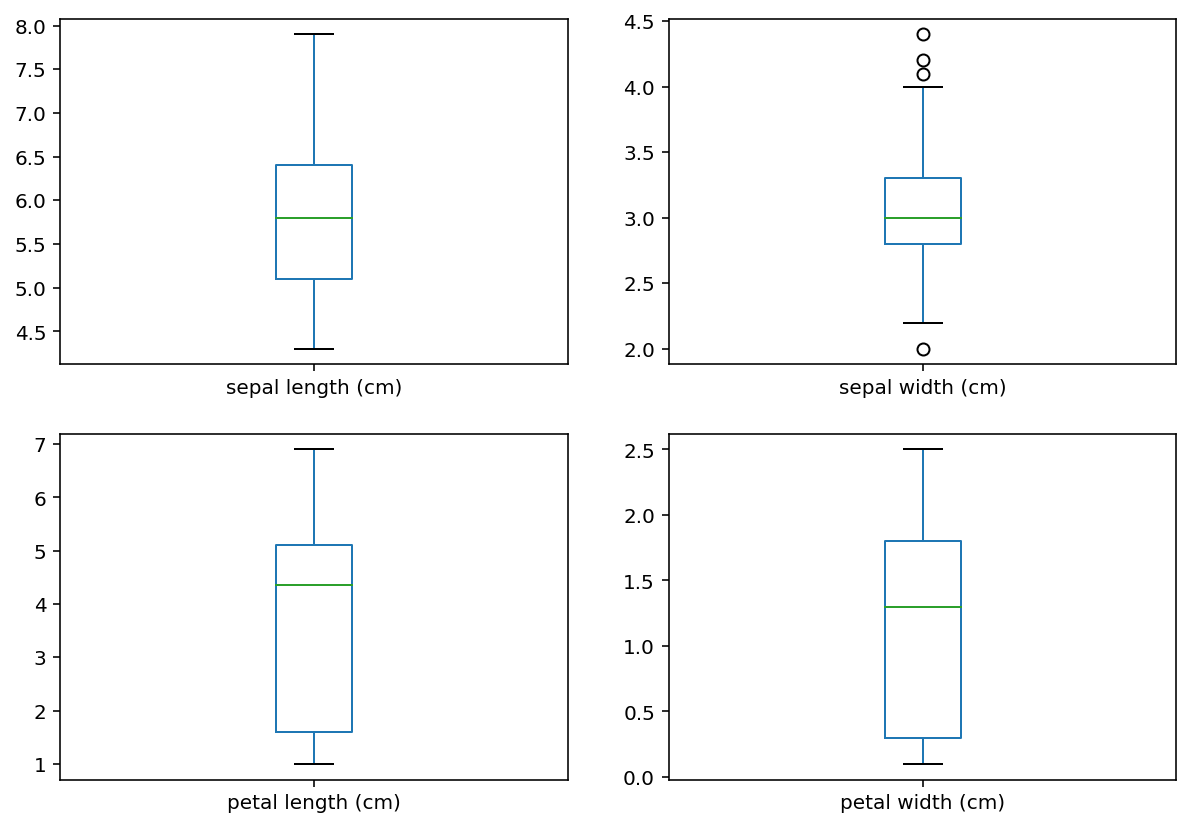

In [11]:
# box and whisker plots
data_x.plot(kind='box', subplots=True, layout=(2,2), sharex=False, sharey=False)
plt.show()

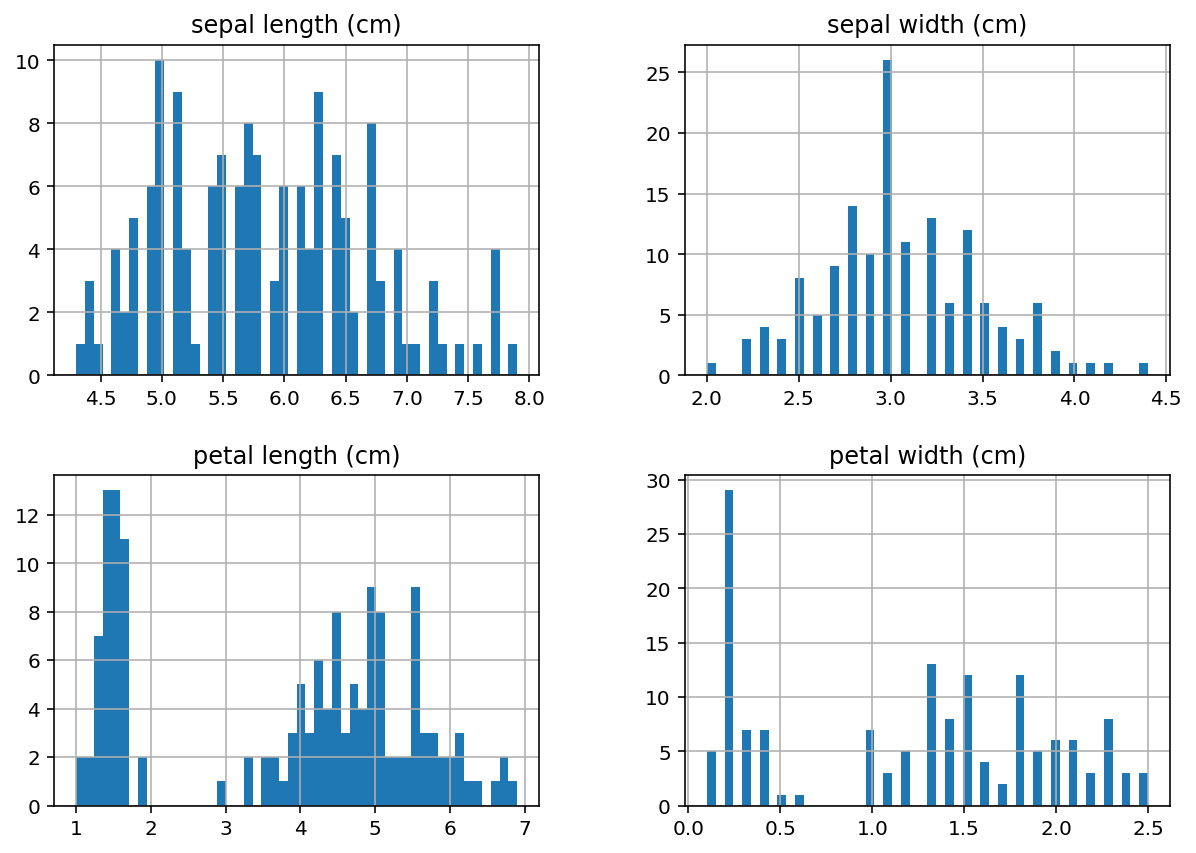

In [12]:
data_x.hist(bins = 50)
plt.show()

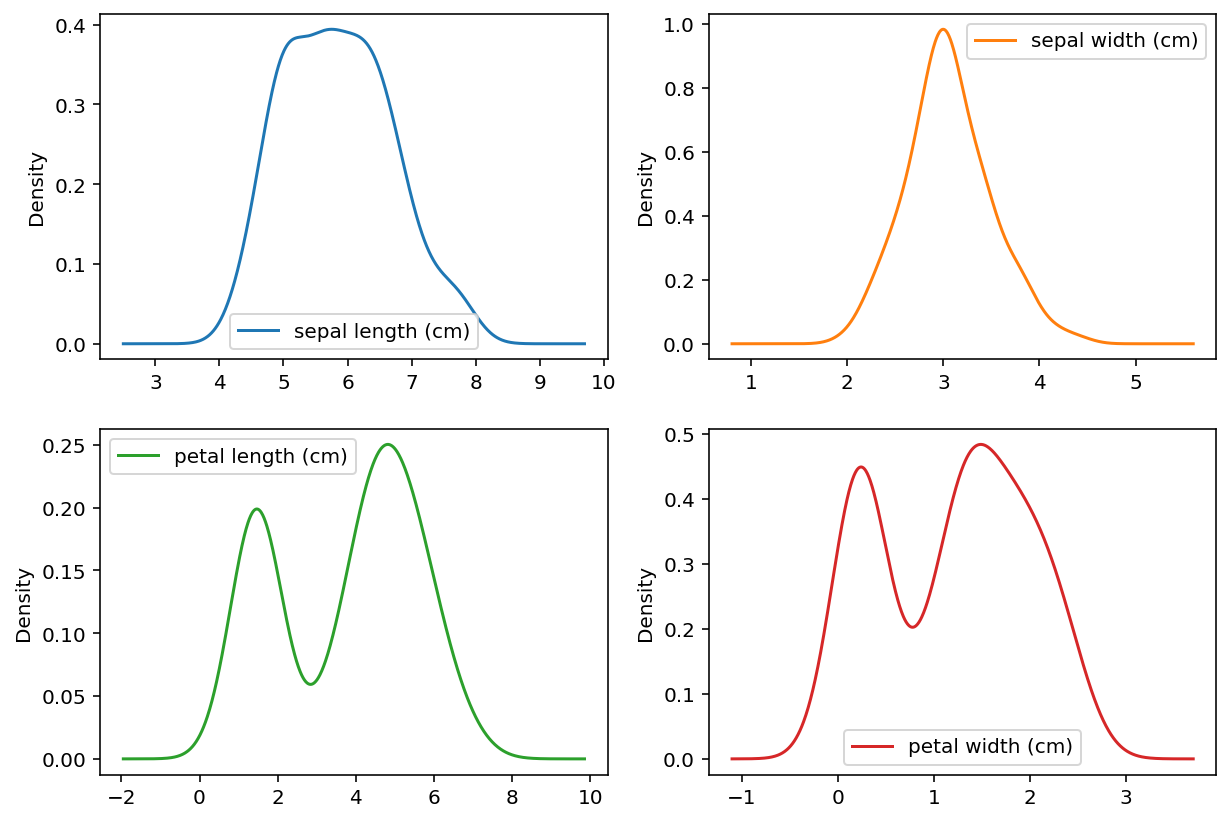

In [13]:
data_x.plot(kind='density', subplots=True, layout=(2,2), sharex=False, sharey=False)
plt.show()

## Multivariate Plots

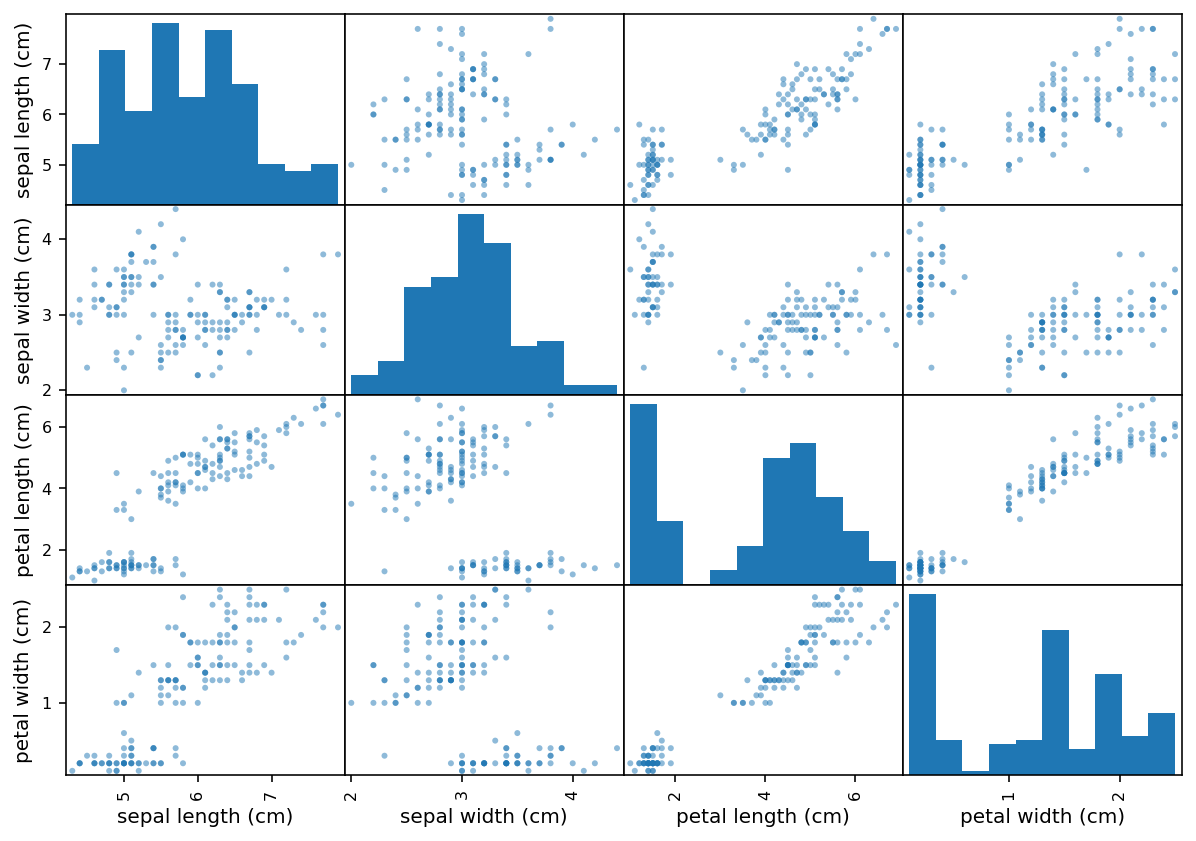

In [14]:
scatter_matrix(data_x)
plt.show()

In [15]:
correlations = data_x.corr()
correlations

,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm)
sepal length (cm),1.000000,-0.117570,0.871754,0.817941
sepal width (cm),-0.117570,1.000000,-0.428440,-0.366126
petal length (cm),0.871754,-0.428440,1.000000,0.962865
petal width (cm),0.817941,-0.366126,0.962865,1.000000


In [16]:
correlations.style.background_gradient(cmap='coolwarm').set_precision(2)

,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm)
sepal length (cm),1.00,-0.12,0.87,0.82
sepal width (cm),-0.12,1.00,-0.43,-0.37
petal length (cm),0.87,-0.43,1.00,0.96
petal width (cm),0.82,-0.37,0.96,1.00


# Quantum Neural Network

In [17]:
scaler_mm = MinMaxScaler()
X_data_temp = scaler_mm.fit_transform(X_data)
X_data_temp[:10]

array([[0.22222222, 0.625     , 0.06779661, 0.04166667],
       [0.16666667, 0.41666667, 0.06779661, 0.04166667],
       [0.11111111, 0.5       , 0.05084746, 0.04166667],
       [0.08333333, 0.45833333, 0.08474576, 0.04166667],
       [0.19444444, 0.66666667, 0.06779661, 0.04166667],
       [0.30555556, 0.79166667, 0.11864407, 0.125     ],
       [0.08333333, 0.58333333, 0.06779661, 0.08333333],
       [0.19444444, 0.58333333, 0.08474576, 0.04166667],
       [0.02777778, 0.375     , 0.06779661, 0.04166667],
       [0.16666667, 0.45833333, 0.08474576, 0.        ]])

In [18]:
ohe_transformer = OneHotEncoder(sparse = False)
Y_data_temp = ohe_transformer.fit_transform(Y_data.reshape(-1,1))
Y_data_temp[:10]

array([[1., 0., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       [1., 0., 0.]])

In [19]:
algorithm_globals.random_seed = 42

In [20]:
features = X_data_temp.shape[1]
features

4

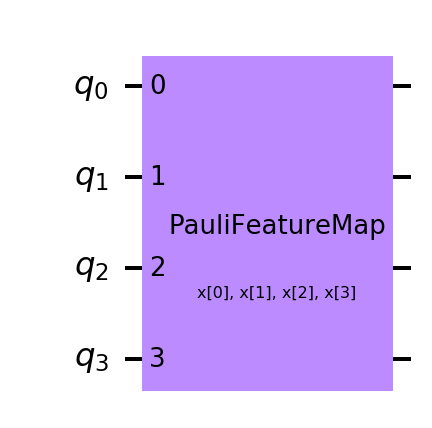

In [21]:
#feature_map = ZZFeatureMap(feature_dimension = features, reps = 1, entanglement = "full")
feature_map = PauliFeatureMap(feature_dimension = features, reps=1, paulis=['Z', 'XX'], entanglement = "full")
feature_map.draw('mpl')

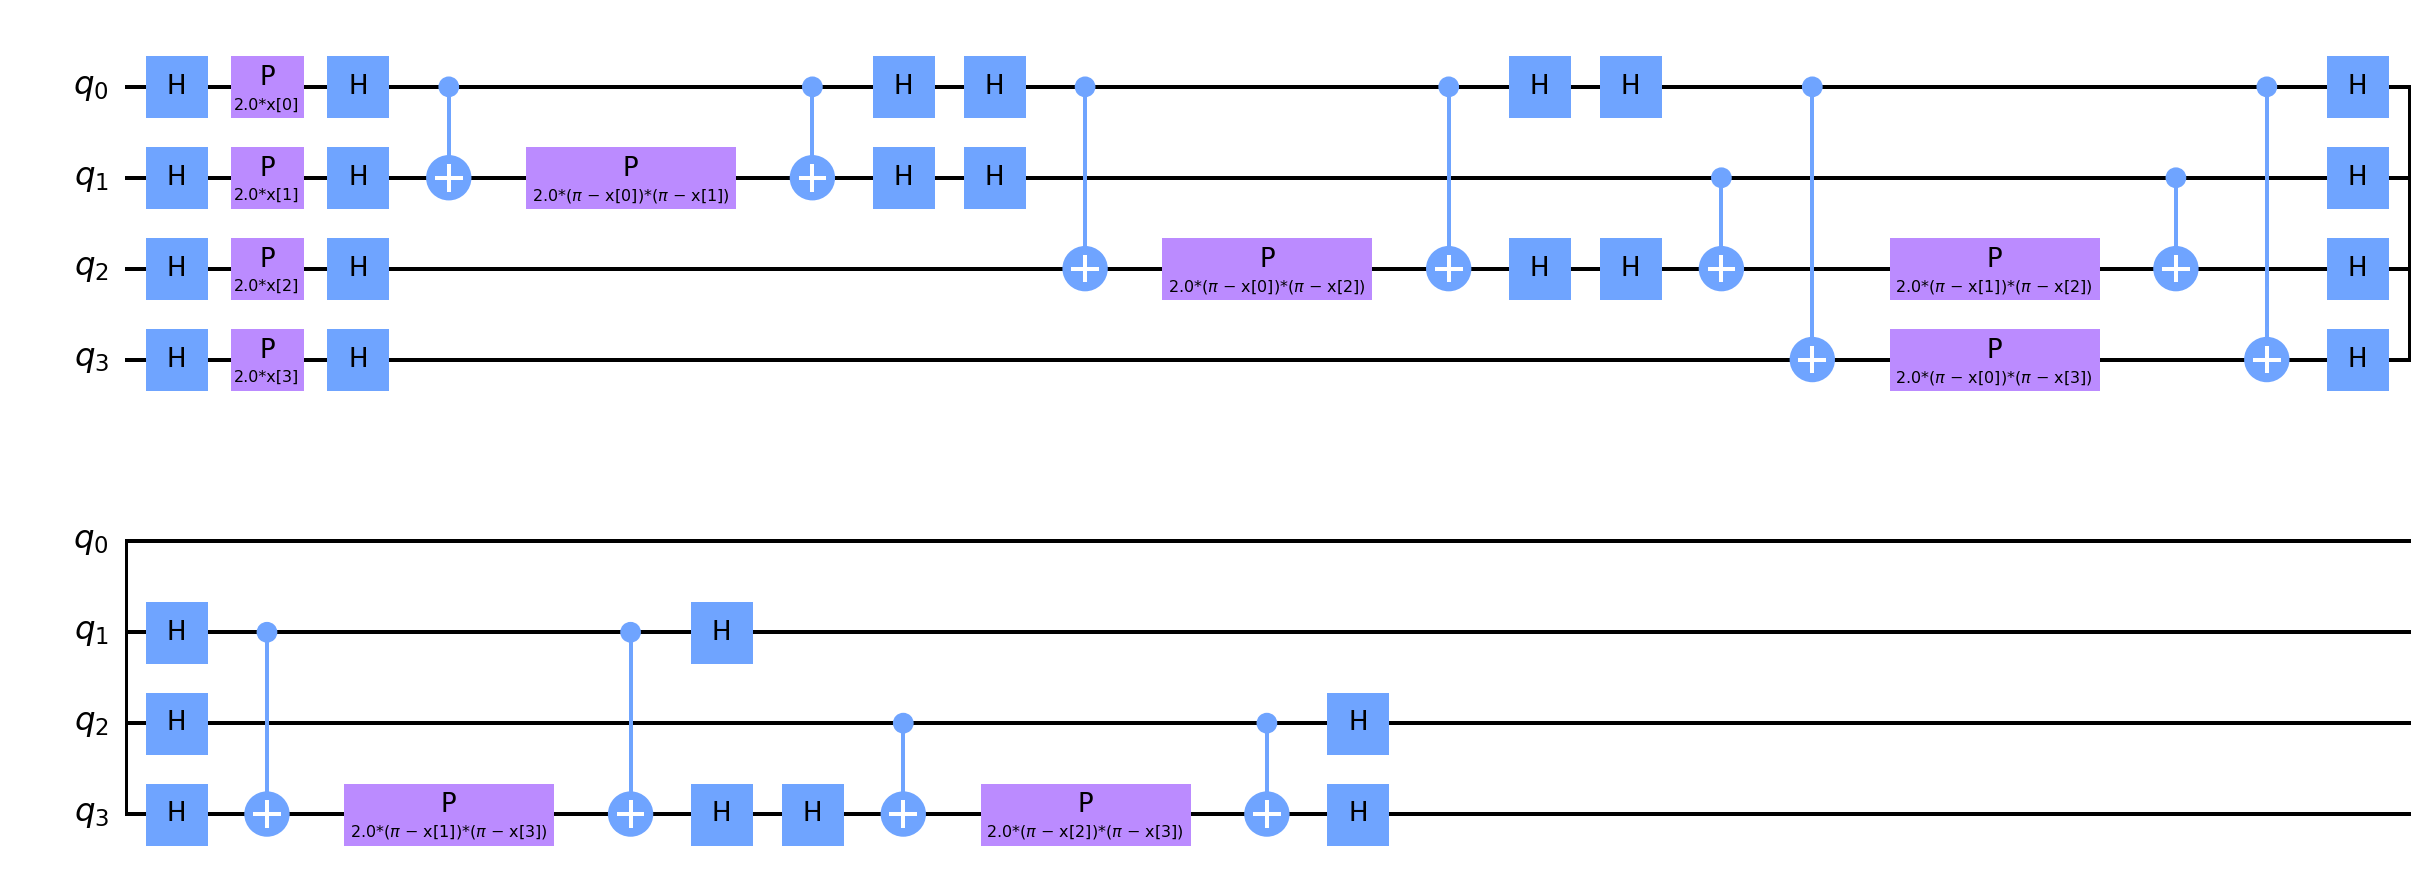

In [22]:
feature_map.decompose().draw('mpl')

In [23]:
num_qubits = features
variational_circ = RealAmplitudes(num_qubits = num_qubits, reps = 4, entanglement = "full")
#variational_circ = EfficientSU2(num_qubits = num_qubits, reps = 4, entanglement = "full")

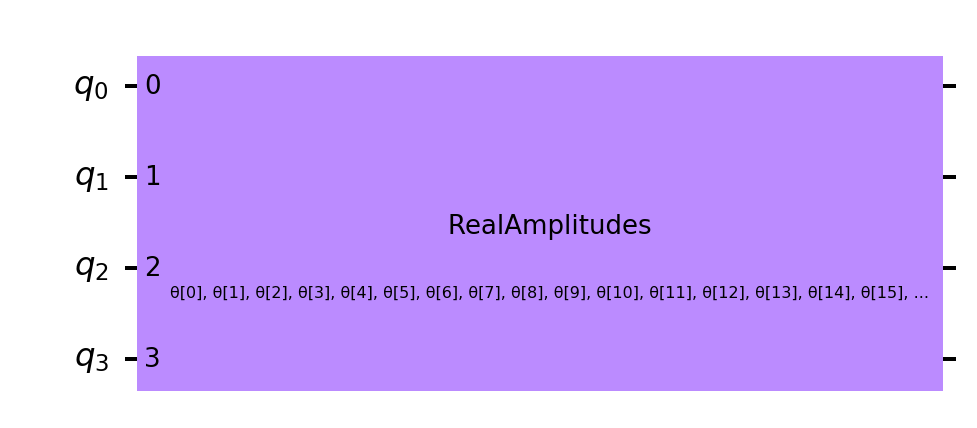

In [24]:
variational_circ.draw('mpl')

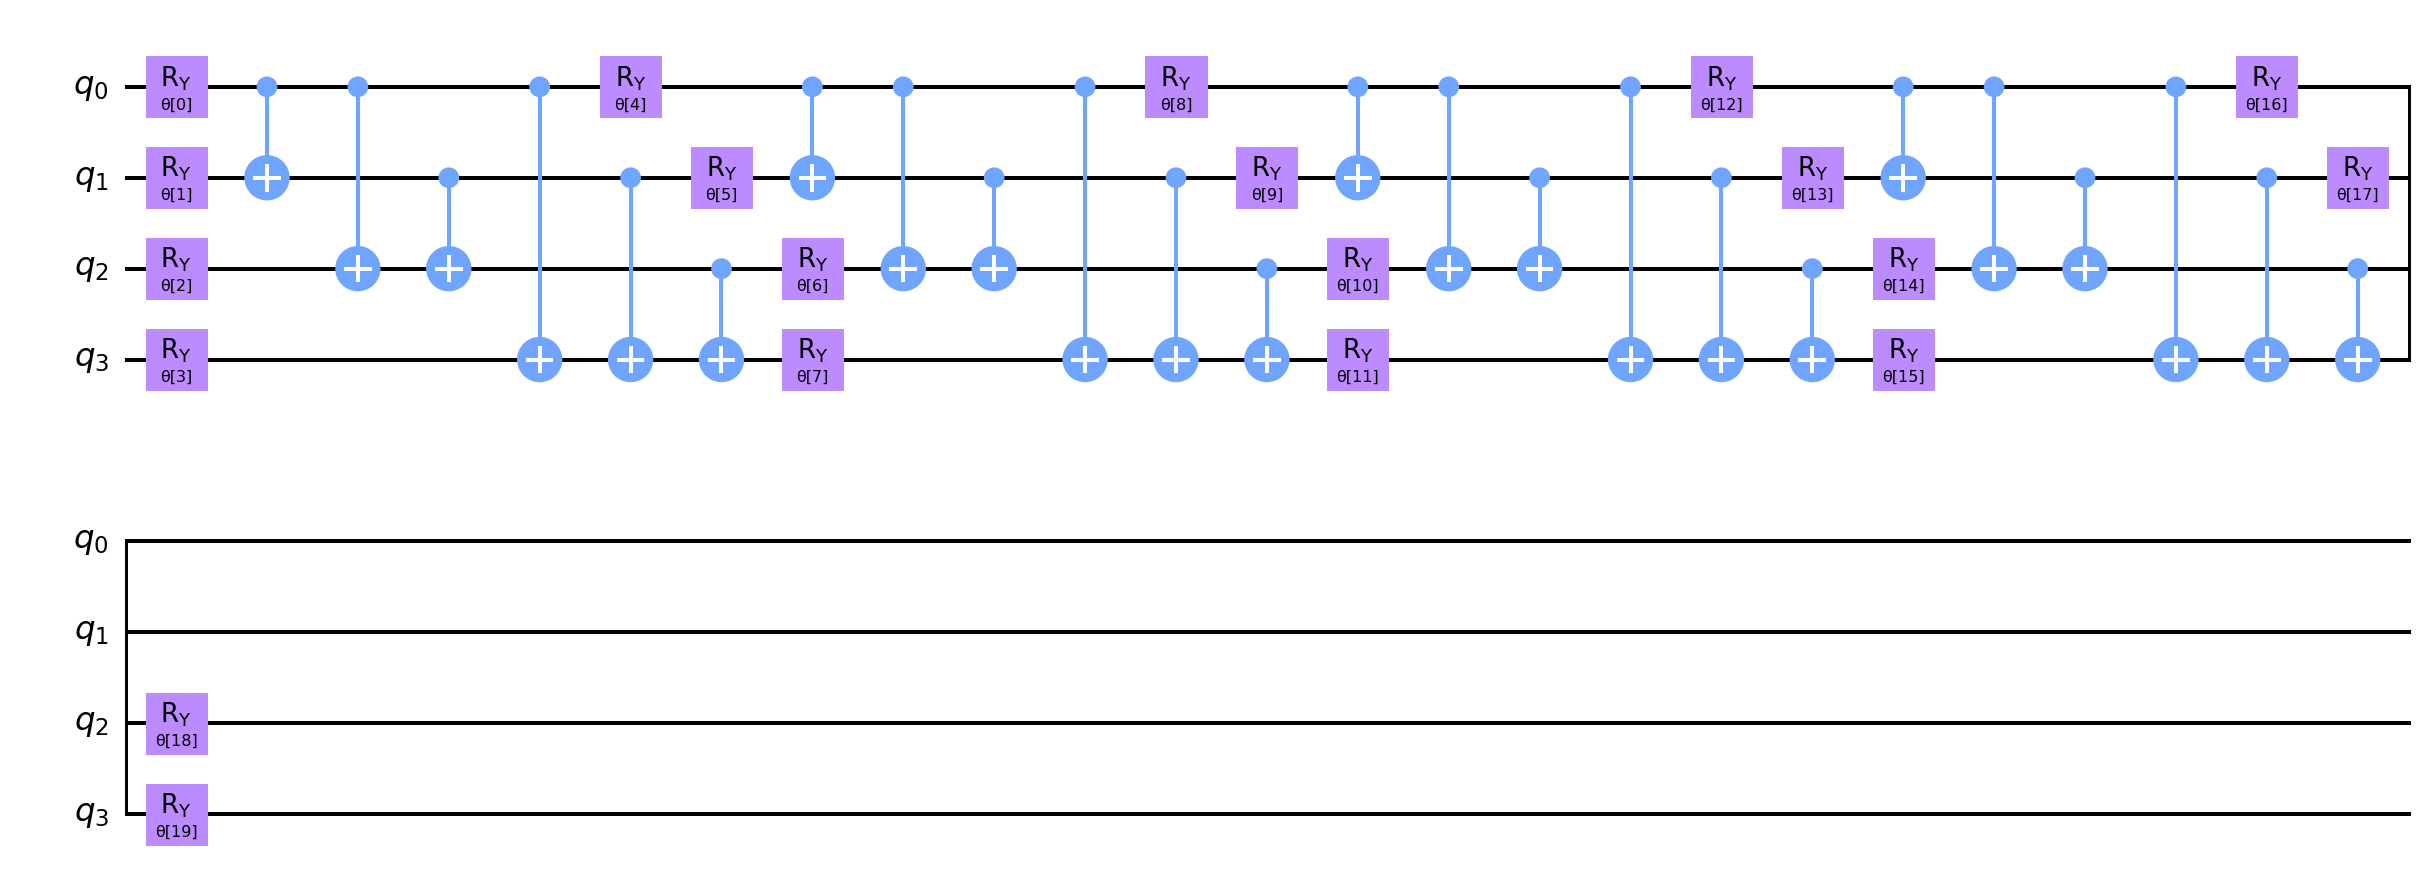

In [25]:
variational_circ.decompose().draw('mpl')

In [26]:
variational_circ.num_parameters

20

In [27]:
backend = Aer.get_backend('statevector_simulator')

In [28]:
# specify the observable
observable = PauliSumOp.from_list([("Z" * num_qubits, 1)])
print(observable)

1.0 * ZZZZ


In [29]:
quantum_instance = QuantumInstance(backend, 
                                   shots = 1024, 
                                   seed_simulator = algorithm_globals.random_seed, 
                                   seed_transpiler = algorithm_globals.random_seed)

In [61]:
# define two layer QNN
two_layers = False

if two_layers:
    
    qnn_architecture = TwoLayerQNN(
        num_qubits, 
        feature_map=feature_map, 
        ansatz=variational_circ, 
        observable=observable, 
        quantum_instance=quantum_instance
    )

else:
    
    num_inputs = features

    # construct quantum circuit
    qc = QuantumCircuit(num_inputs)
    qc.append(feature_map, range(num_inputs))
    qc.append(variational_circ, range(num_inputs))
    qc.decompose().draw(output="mpl")

    # parity maps bitstrings to 0 or 1
    def parity(x):
        return "{:b}".format(x).count("1") % 2

    output_shape = len(np.unique(Y_data))  # corresponds to the number of classes, possible outcomes of the (parity) mapping.

    # construct QNN
    qnn_architecture = CircuitQNN(
        circuit=qc,
        input_params=feature_map.parameters,
        weight_params=variational_circ.parameters,
        #interpret=parity,
        output_shape=output_shape,
        gradient=Gradient(),
        quantum_instance=quantum_instance,
    )

No interpret function given, output_shape will be automatically determined as 2^num_qubits.


In [62]:
# define (random) input and weights
input3 = algorithm_globals.random.random(qnn_architecture.num_inputs)
weights3 = algorithm_globals.random.random(qnn_architecture.num_weights)

In [63]:
# QNN forward pass
qnn_architecture.forward(input3, weights3)

array([[0.13301908, 0.04036156, 0.07119863, 0.05886142, 0.06189847,
        0.01685374, 0.04682908, 0.01427676, 0.09603861, 0.0406002 ,
        0.04231829, 0.00807833, 0.15471838, 0.0925293 , 0.05045869,
        0.07195946]])

In [64]:
# QNN backward pass
qnn_architecture.backward(input3, weights3)

(None,
 array([[[ 2.17929880e-02, -3.88245870e-02,  8.53401958e-02,
           1.63429583e-01,  4.89478864e-02, -9.14044214e-03,
           1.00959952e-01,  1.98101045e-01, -1.72870504e-02,
          -2.33408351e-02,  2.68275485e-02,  1.32149723e-01,
          -6.13051344e-02, -1.64864963e-03,  8.94206956e-02,
           1.39563819e-01,  7.09032215e-02,  8.56652858e-02,
          -2.79821751e-02,  1.00055391e-01],
         [-2.10279538e-02,  3.73266747e-02,  9.66113281e-03,
          -3.63366399e-02, -3.67139753e-03, -4.67228481e-03,
           2.09383882e-02,  8.69376897e-03,  6.12769796e-02,
           1.92758877e-02, -2.21308673e-02, -1.50360485e-03,
           5.82431521e-02,  2.95589482e-02,  1.15256955e-02,
           2.08784046e-02, -7.09032215e-02,  3.90121350e-02,
           4.06538737e-03, -1.88240097e-02],
         [ 2.29146566e-02,  5.06396862e-02,  3.04161783e-02,
          -6.14068968e-03, -1.78339147e-02, -7.31286760e-02,
          -7.22303931e-03,  1.60001257e-03, -5.66

In [65]:
X_data.shape

(150, 4)

In [66]:
Y_data.shape

(150,)

In [67]:
X_train, X_test, y_train, y_test = train_test_split(X_data_temp, Y_data_temp, test_size=0.2, random_state=algorithm_globals.random_seed)

In [68]:
X_train.shape

(120, 4)

In [69]:
y_train.shape

(120, 3)

In [70]:
optimizer = COBYLA(maxiter = 400, tol = 0.001)

In [71]:
def callback_graph(weights, obj_func_eval):
    clear_output(wait = True)
    objective_func_vals.append(obj_func_eval)
    plt.title("Objective function value against iteration")
    plt.xlabel("Iteration")
    plt.ylabel("Objective function value")
    plt.plot(range(len(objective_func_vals)), objective_func_vals)
    plt.show()

In [72]:
qnnc = NeuralNetworkClassifier(qnn_architecture, optimizer=optimizer, callback=callback_graph)

In [73]:
start = time.time()

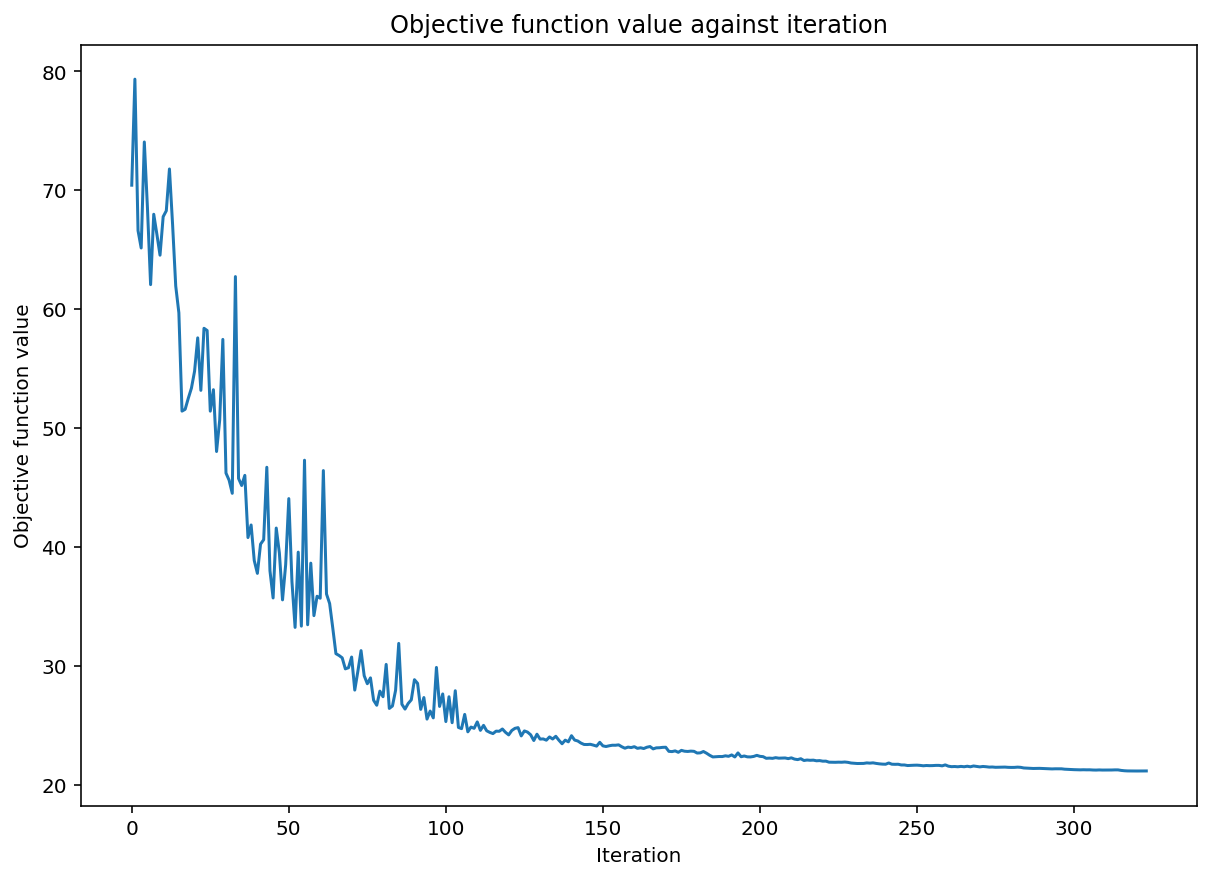

In [ ]:
plt.rcParams['figure.figsize'] = [10, 7]

objective_func_vals = []

y_train_fit = y_train.T[0]

qnnc.fit(X_train, y_train_fit)

elapsed = time.time() - start

print("Time elapsed: ", elapsed)

plt.show()

In [ ]:
print("Train score: {:.2f}%".format(qnnc.score(X_train, y_train_fit)*100))

y_test_score = np.array(y_test).T[0]

print("Test score: {:.2f}%".format(qnnc.score(X_test, y_test_score)*100))

#### More examples at:
https://github.com/Qiskit/qiskit-machine-learning/blob/main/docs/tutorials/02_neural_network_classifier_and_regressor.ipynb

https://qiskit.org/documentation/machine-learning/tutorials/01_neural_networks.html